In [1]:
import sys
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stat

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
# Files and Paths
output_dir = "hist_exploratory_output/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [10]:
df = pd.read_csv("assembled_bins/hist_bin_C_ID_0.csv")
print('read in')
print(df.columns)
print(df.category_2.value_counts())
sdfjskdfjs
hist_month_diff = df.loc[:, ['card_id', 'purchase_date', 'month_lag']]
hist_month_diff.loc[:, 'hist_trans_month_diff'] = (
        dt.datetime.today() - pd.to_datetime(hist_month_diff['purchase_date'])
    ).dt.days//30
hist_month_diff['hist_trans_month_diff'] += hist_month_diff['month_lag']
hist_month_diff = hist_month_diff.groupby(
        by=['card_id'],
        as_index=False
    ).agg({'hist_trans_month_diff': [np.std, np.mean]})
print(hist_month_diff.head())
hist_month_diff.columns = [x[0] if x[1] == '' else x[0]+"_"+x[1] for x in hist_month_diff.columns]
print(hist_month_diff.head())

#df_new = pd.get_dummies(df, columns=['merchant_id'])
#print(df_new.columns)

read in
Index([u'authorized_flag', u'card_id', u'city_id', u'category_1',
       u'installments', u'category_3', u'merchant_category_id', u'merchant_id',
       u'month_lag', u'purchase_amount', u'purchase_date', u'category_2',
       u'state_id', u'subsector_id', u'merchant_group_id',
       u'merchant_category_id_merch', u'subsector_id_merch', u'numerical_1',
       u'numerical_2', u'category_1_merch', u'most_recent_sales_range',
       u'most_recent_purchases_range', u'avg_sales_lag3',
       u'avg_purchases_lag3', u'active_months_lag3', u'avg_sales_lag6',
       u'avg_purchases_lag6', u'active_months_lag6', u'avg_sales_lag12',
       u'avg_purchases_lag12', u'active_months_lag12', u'category_4',
       u'city_id_merch', u'state_id_merch', u'category_2_merch', u'binId'],
      dtype='object')
1.0    1030386
3.0     241910
5.0     229493
4.0     167577
2.0      62490
Name: category_2, dtype: int64


NameError: name 'sdfjskdfjs' is not defined

In [45]:
df_train = pd.read_csv("assembled_bins/train_bin_C_ID_0.csv")
df_train.columns

Index([u'first_active_month', u'card_id', u'feature_1', u'feature_2',
       u'feature_3', u'target', u'binId'],
      dtype='object')

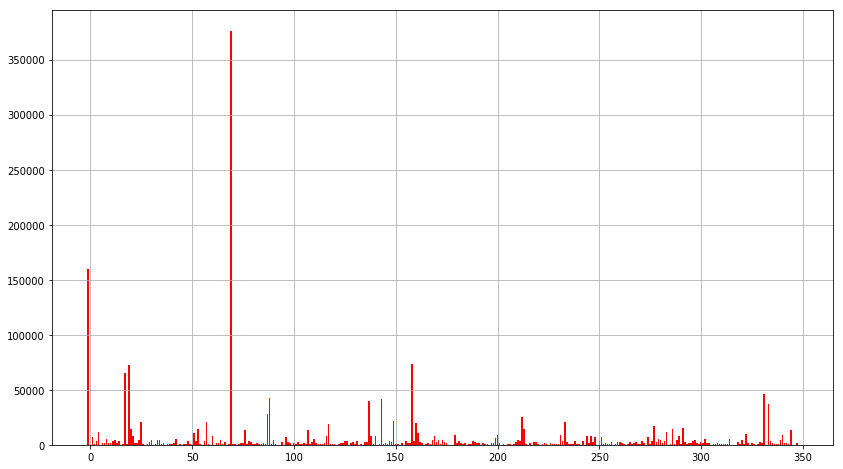

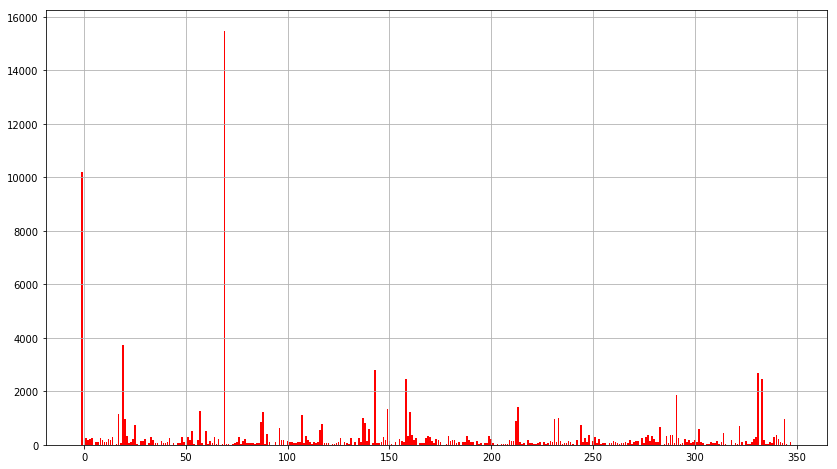

In [17]:
# City ID bars
vc = df.groupby(by=['city_id'], as_index=False).agg({'card_id': [pd.Series.nunique, 'count']})
vc.columns = list([x[0] if x[1] == '' else x[1] for x in vc.columns])
figure = plt.figure(figsize=(14, 8))
vc.sort_values(by=['count'], ascending=False, inplace=True)
plt.bar(vc['city_id'], vc['count'], color='red')
plt.grid()
plt.show(block=False)

figure = plt.figure(figsize=(14, 8))
vc.sort_values(by=['nunique'], ascending=False, inplace=True)
plt.bar(vc['city_id'], vc['nunique'], color='red')
plt.grid()
plt.show(block=False)

In [40]:
# Get city_id indicator wide
trans_hist_wide = df.pivot_table(
    index=['card_id'],
    columns=['city_id'],
    values=['merchant_id'],
    aggfunc='count'
)
trans_hist_wide.reset_index(inplace=True)
trans_hist_wide.columns = [x[0] if x[1] == '' else "city_id_{}_trans_count".format(str(x[1])) 
                            for x in trans_hist_wide.columns]
# FillNA
count_cols = [x for x in trans_hist_wide.columns if "trans_count" in x]
for col in count_cols:
    trans_hist_wide[col].fillna(0, inplace=True)

# PCA
pca = PCA(n_components=4)
x_decomp = pca.fit_transform(trans_hist_wide[count_cols])
print(pca.explained_variance_ratio_)

pca_loadings = pca.components_.T
df_pcs = pd.DataFrame(pca_loadings[:,:4])
df_pcs.columns = ['city_id_pc_0', 'city_id_pc_1', 'city_id_pc_2', 'city_id_pc_3']
trans_hist_wide = pd.concat(
    objs=[trans_hist_wide[['card_id']], df_pcs],
    axis=1
)
print(trans_hist_wide.head())

[0.19762991 0.0662844  0.05016835 0.04549544]
           card_id  city_id_pc_0  city_id_pc_1  city_id_pc_2
0  C_ID_00007093c1      0.041542      0.042505      0.949061
1  C_ID_0001238066     -0.000009     -0.000909     -0.001290
2  C_ID_0001506ef0     -0.000103     -0.000107     -0.000286
3  C_ID_0001793786     -0.000080     -0.000662     -0.000580
4  C_ID_000183fdda     -0.001683     -0.001614      0.004676


In [42]:
# Categories
vc_cat1 = df.category_1.value_counts()
print(vc_cat1)
vc_cat2 = df.category_2.value_counts()
print(vc_cat2)
vc_cat3 = df.category_3.value_counts()
print(vc_cat3)


N    1768219
Y     134707
Name: category_1, dtype: int64
1.0    1030386
3.0     241910
5.0     229493
4.0     167577
2.0      62490
Name: category_2, dtype: int64
A    1023010
B     748261
C     120296
Name: category_3, dtype: int64
